Useful links:

https://medium.com/@imabhi1216/fine-tuning-a-vision-transformer-vit-model-with-a-custom-dataset-37840e4e9268#f0a3

https://www.kaggle.com/code/luthei/vit-vs-cnn-on-wikiart/notebook#3.2-Test-Accuracy



In [78]:
# !pip install datasets

In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset
https://huggingface.co/datasets/huggan/wikiart

In [81]:
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

In [82]:
dataset = load_dataset("huggan/wikiart", split="train")

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

In [83]:
print(f"Total number of records: {len(dataset)}")
print(f"Number of columns: {len(dataset.column_names)}")
print(dataset.column_names)

Total number of records: 81444
Number of columns: 4
['image', 'artist', 'genre', 'style']


In [84]:
unique_genres = set(dataset['genre'])
print(f"Number of genres: {unique_genres.__len__()}")
print(f"Unique genres: {unique_genres}")

Number of genres: 11
Unique genres: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [85]:
unique_style = set(dataset['style'])
print(f"Number of styles: {unique_style.__len__()}")
print(f"Unique styles: {unique_style}")

Number of styles: 27
Unique styles: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


We will be using only 2 columns: image and genre

In [86]:
df = pd.DataFrame(dataset['genre'], columns=['genre'])

genre_counts = df['genre'].value_counts()
sorted_counts = genre_counts.sort_index(ascending=True)

sorted_counts_df = pd.DataFrame(sorted_counts).reset_index()
sorted_counts_df.columns = ['genre', 'count']
#sorted_counts_df.style.hide_index()


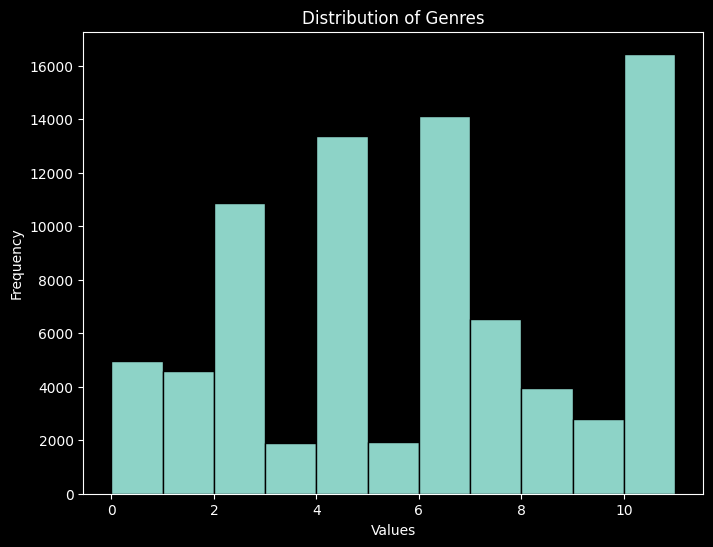

In [87]:
plot_histogram(dataset['genre'], "Distribution of Genres")

Concerning disproportion  in distribution of genres. This may negatively impact the classification results. 

In [88]:
list_of_images = []
for genre in unique_genres:
    for i in range(len(dataset)):
        if dataset[i]['genre'] == genre:
            list_of_images.append(dataset[i]['image'])
            break

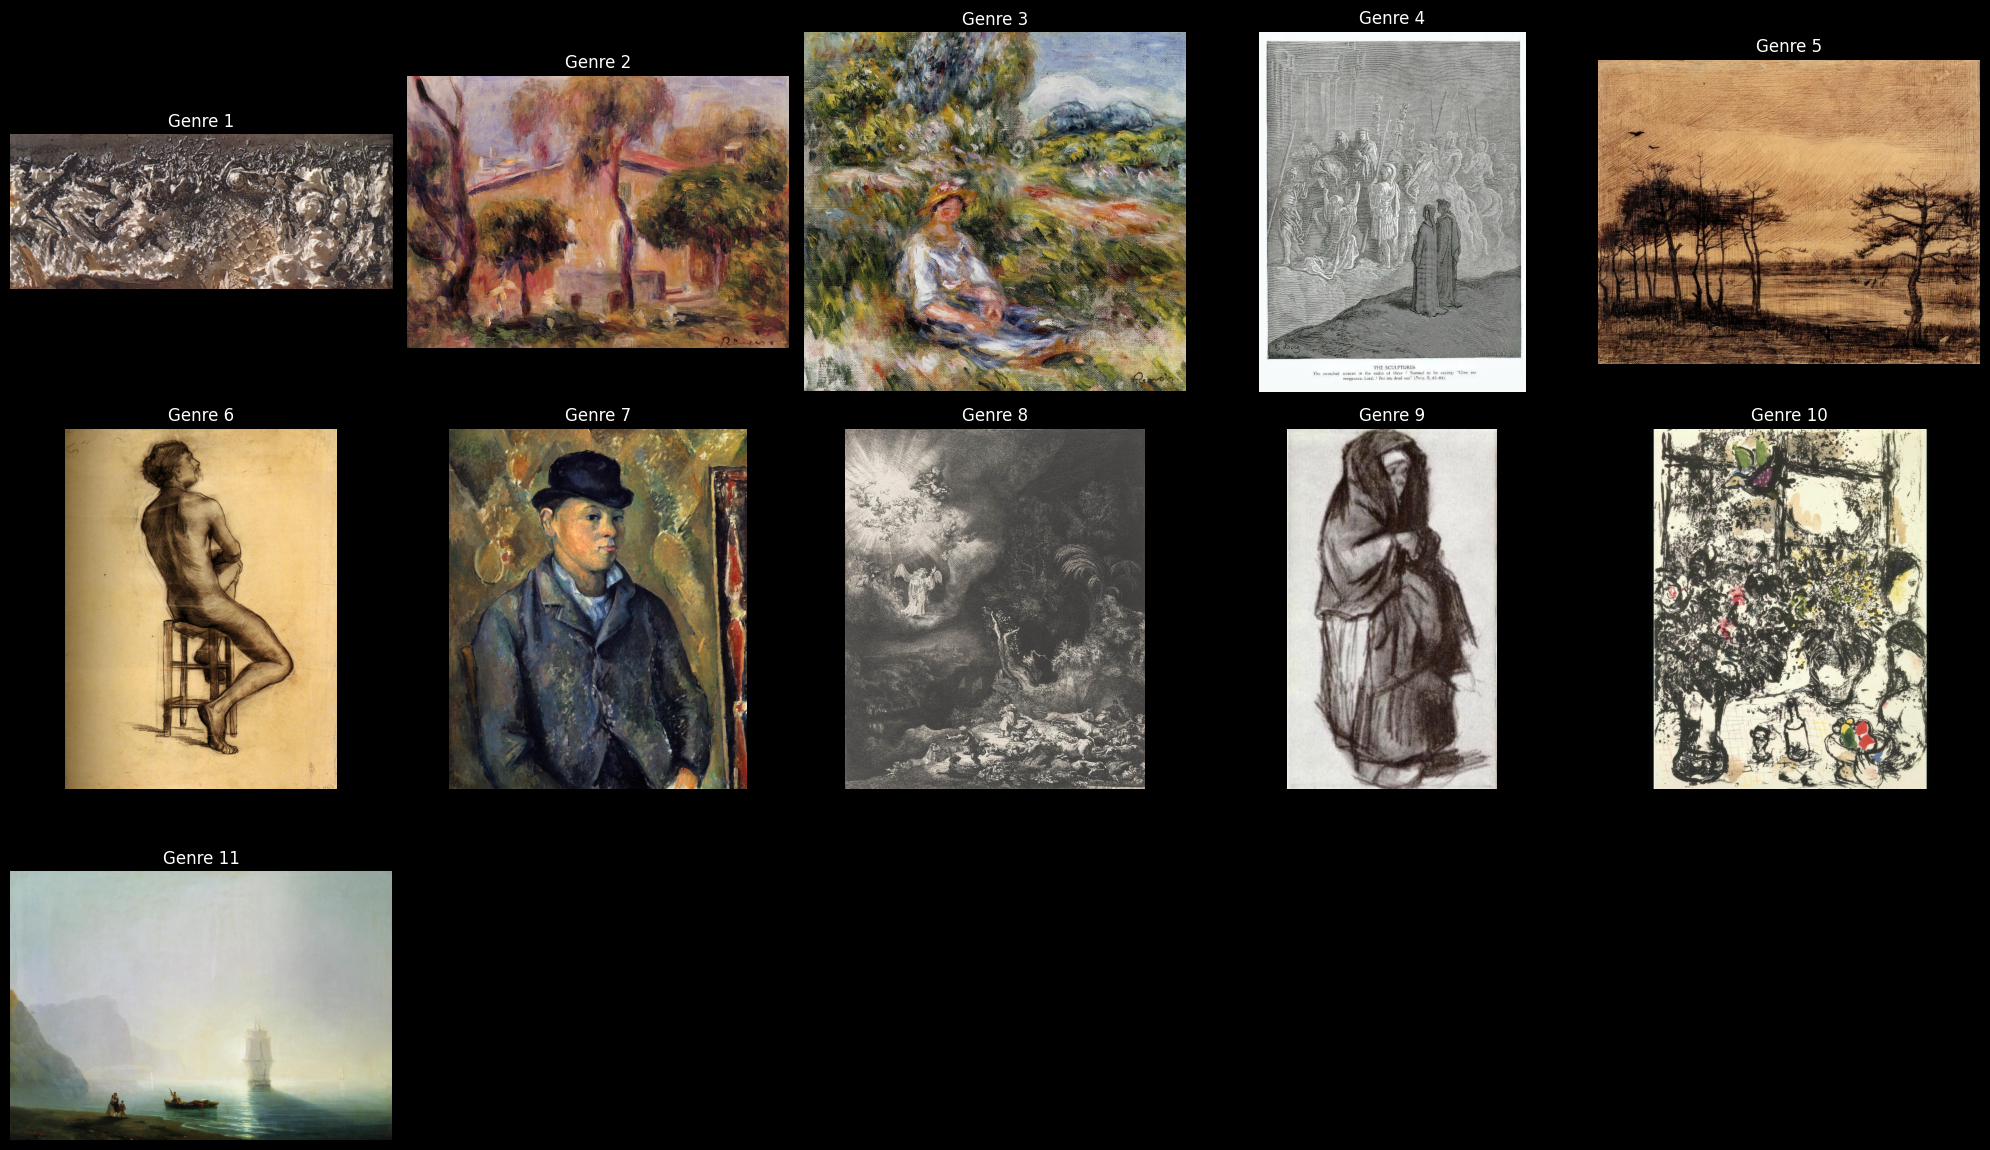

In [89]:
plt.figure(figsize=(20, 20))
for i in range(len(list_of_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(list_of_images[i])
    plt.title(f"Genre {i + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## ViT

In [90]:
from transformers import ViTImageProcessor, ViTForImageClassification, Trainer, TrainingArguments

In [91]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


In [92]:
from collections import Counter
import random

# Count samples per (genre, style)
counter = Counter(dataset['style'])
min_count = min(counter.values())

# Group indices by (genre, style)
grouped_indices = {}
for idx, (s) in enumerate(dataset['style']):
    grouped_indices.setdefault(s, []).append(idx)

# Sample min_count indices from each group
selected_indices = []
for indices in grouped_indices.values():
    selected_indices.extend(random.sample(indices, min_count))

# Select balanced subset
dataset = dataset.select(selected_indices)
print(f"Balanced dataset size: {len(dataset)}")

Balanced dataset size: 2646


Encoding genre labels

In [106]:
genres = list(set(dataset['genre']))
styles = list(set(dataset['style']))

label2id = {g: i for i, g in enumerate(genres)}
id2label = {i: g for g, i in label2id.items()}

style2id = {s: i for i, s in enumerate(styles)}
id2style = {i: s for s, i in style2id.items()}

def encode_labels(example):
    example['genre_label'] = label2id[example['genre']]
    example['style_label'] = style2id[example['style']]
    return example

dataset = dataset.map(encode_labels)

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

KeyError: 10

Preprocessing images

In [17]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def preprocess(example):
    inputs = processor(images=example['image'], return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'][0]
    return example

dataset = dataset.map(preprocess)

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Splitting dataset into train and test sets

In [18]:
def collate_fn(examples):
    pixel_values = torch.stack([
        torch.tensor(example["pixel_values"]) if not isinstance(example["pixel_values"], torch.Tensor)
        else example["pixel_values"]
        for example in examples
    ])
    genre_labels = torch.tensor([example["genre_label"] for example in examples])
    style_labels = torch.tensor([example["style_label"] for example in examples])
    return {
        "pixel_values": pixel_values,
        "genre_labels": genre_labels,
        "style_labels": style_labels
    }

In [19]:
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
eval_dataset = split['test']

In [20]:
import torch
import torch.nn as nn
from transformers import ViTModel

class ViTMultiTask(nn.Module):
    def __init__(self, num_genres, num_styles):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        hidden_size = self.vit.config.hidden_size
        self.genre_head = nn.Linear(hidden_size, num_genres)
        self.style_head = nn.Linear(hidden_size, num_styles)

    def forward(self, pixel_values, **kwargs):
        outputs = self.vit(pixel_values=pixel_values)
        pooled = outputs.pooler_output
        genre_logits = self.genre_head(pooled)
        style_logits = self.style_head(pooled)
        return genre_logits, style_logits

In [21]:
# Initialize the ViT model with your genre classes
model = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTMultiTask(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn):

In [64]:
import evaluate
from transformers import EvalPrediction
from sklearn.metrics import top_k_accuracy_score

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
def compute_metrics(eval_pred: EvalPrediction):
    # Extract and convert to numpy if needed
    genre_logits, style_logits = eval_pred.predictions
    if isinstance(genre_logits, torch.Tensor):
        genre_logits = genre_logits.cpu().numpy()
        style_logits = style_logits.cpu().numpy()
    
    genre_labels = eval_pred.label_ids["genre_labels"]
    style_labels = eval_pred.label_ids["style_labels"]
    if isinstance(genre_labels, torch.Tensor):
        genre_labels = genre_labels.cpu().numpy()
        style_labels = style_labels.cpu().numpy()
    
    genre_preds = np.argmax(genre_logits, axis=1)
    style_preds = np.argmax(style_logits, axis=1)
    genre_acc = (genre_preds == genre_labels).mean()
    style_acc = (style_preds == style_labels).mean()
    avg_acc = (genre_acc + style_acc) / 2
    return {
        "eval_genre_accuracy": genre_acc,
        "eval_style_accuracy": style_acc,
        "eval_avg_accuracy": avg_acc
    }

In [66]:
class MultiTaskTrainer(Trainer):
    def __init__(self, *args, compute_metrics=None, **kwargs):
        super().__init__(*args, compute_metrics=compute_metrics, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        pixel_values = inputs["pixel_values"].to(model.vit.device)
        genre_labels = inputs["genre_labels"].to(model.vit.device)
        style_labels = inputs["style_labels"].to(model.vit.device)
        genre_logits, style_logits = model(pixel_values)
        loss_fct = nn.CrossEntropyLoss()
        genre_loss = loss_fct(genre_logits, genre_labels)
        style_loss = loss_fct(style_logits, style_labels)
        loss = genre_loss + style_loss  # This is a scalar tensor
        if return_outputs:
            outputs = (genre_logits, style_logits)
            return loss, outputs
        return loss

    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        # Move inputs to appropriate device
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(model.vit.device)

        with torch.no_grad():
            # Forward pass
            genre_logits, style_logits = model(inputs["pixel_values"])

            # Get labels
            genre_labels = inputs["genre_labels"]
            style_labels = inputs["style_labels"]

            # Compute loss
            loss_fct = nn.CrossEntropyLoss()
            genre_loss = loss_fct(genre_logits, genre_labels)
            style_loss = loss_fct(style_logits, style_labels)
            loss = genre_loss + style_loss

        if prediction_loss_only:
            return (loss, None, None)

        return (
            loss.detach(),
            (genre_logits.detach(), style_logits.detach()),  # Keep as tensors, don't convert to numpy
            {"genre_labels": genre_labels.detach(),
             "style_labels": style_labels.detach()}  # Keep as tensors
        )

In [67]:

train_args = TrainingArguments(
    output_dir="output-models",
    per_device_train_batch_size=16,
    num_train_epochs=2,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    eval_strategy='steps',
    metric_for_best_model='eval_avg_accuracy', 
)

In [68]:
trainer = MultiTaskTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss,Validation Loss,Genre Accuracy,Style Accuracy,Avg Accuracy
10,0.296100,4.673386,0.492453,0.260377,0.376415
20,4.320000,4.289241,0.507547,0.292453,0.400000
30,4.311500,3.898008,0.554717,0.300000,0.427358
40,3.787500,3.717645,0.550943,0.335849,0.443396
50,3.701500,3.362352,0.586792,0.350943,0.468868
60,3.478400,3.541613,0.569811,0.347170,0.458491
70,3.381600,3.416075,0.588679,0.305660,0.447170
80,3.377400,3.282251,0.594340,0.358491,0.476415
90,3.227000,3.179187,0.592453,0.364151,0.478302
100,3.391900,3.055173,0.605660,0.394340,0.500000


TrainOutput(global_step=266, training_loss=2.2504522441921377, metrics={'train_runtime': 2140.5164, 'train_samples_per_second': 1.977, 'train_steps_per_second': 0.124, 'total_flos': 0.0, 'train_loss': 2.2504522441921377, 'epoch': 2.0})

In [69]:
outputs = trainer.predict(eval_dataset)
print(outputs.metrics)

{'test_loss': 2.6551942825317383, 'test_eval_genre_accuracy': 0.6660377358490566, 'test_eval_style_accuracy': 0.4679245283018868, 'test_eval_avg_accuracy': 0.5669811320754716, 'test_runtime': 61.0125, 'test_samples_per_second': 8.687, 'test_steps_per_second': 1.098}


<Figure size 1000x800 with 0 Axes>

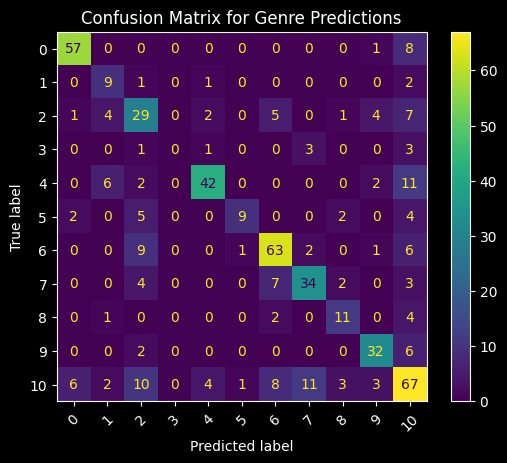

<Figure size 1000x800 with 0 Axes>

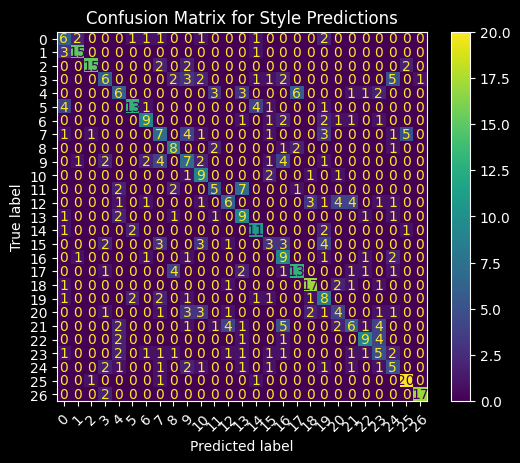

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract predictions and true labels for genres and styles
genre_logits, style_logits = outputs.predictions
genre_preds = np.argmax(genre_logits, axis=1)
style_preds = np.argmax(style_logits, axis=1)

genre_labels = outputs.label_ids["genre_labels"]
style_labels = outputs.label_ids["style_labels"]

# Compute confusion matrices
genre_cm = confusion_matrix(genre_labels, genre_preds)
style_cm = confusion_matrix(style_labels, style_preds)

# Display confusion matrix for genres
plt.figure(figsize=(10, 8))
genre_disp = ConfusionMatrixDisplay(confusion_matrix=genre_cm, display_labels=id2label.values())
genre_disp.plot(xticks_rotation=45, cmap="viridis")
plt.title("Confusion Matrix for Genre Predictions")
plt.show()

# Display confusion matrix for styles
plt.figure(figsize=(10, 8))
style_disp = ConfusionMatrixDisplay(confusion_matrix=style_cm, display_labels=id2style.values())
style_disp.plot(xticks_rotation=45, cmap="viridis")
plt.title("Confusion Matrix for Style Predictions")
plt.show()

In [108]:
from sklearn.metrics import classification_report

print(classification_report(genre_labels, genre_preds, target_names=dataset.features["genre"].names))

                    precision    recall  f1-score   support

 abstract_painting       0.86      0.86      0.86        66
         cityscape       0.41      0.69      0.51        13
    genre_painting       0.46      0.55      0.50        53
      illustration       0.00      0.00      0.00         8
         landscape       0.84      0.67      0.74        63
     nude_painting       0.82      0.41      0.55        22
          portrait       0.74      0.77      0.75        82
religious_painting       0.68      0.68      0.68        50
  sketch_and_study       0.58      0.61      0.59        18
        still_life       0.74      0.80      0.77        40
     Unknown Genre       0.55      0.58      0.57       115

          accuracy                           0.67       530
         macro avg       0.61      0.60      0.59       530
      weighted avg       0.67      0.67      0.66       530



C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [109]:
from sklearn.metrics import classification_report

print(classification_report(style_labels, style_preds, target_names=dataset.features["style"].names))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.32      0.40      0.35        15
           Action_painting       0.79      0.79      0.79        19
         Analytical_Cubism       0.88      0.71      0.79        21
               Art_Nouveau       0.38      0.26      0.31        23
                   Baroque       0.33      0.27      0.30        22
      Color_Field_Painting       0.72      0.54      0.62        24
      Contemporary_Realism       0.56      0.50      0.53        18
                    Cubism       0.30      0.29      0.30        24
         Early_Renaissance       0.44      0.57      0.50        14
             Expressionism       0.28      0.29      0.29        24
                   Fauvism       0.39      0.64      0.49        14
          High_Renaissance       0.42      0.29      0.34        17
             Impressionism       0.43      0.26      0.32        23
Mannerism_Late_Renaissance       0.35      0.56